#   [Py4Hw User Guide](../UserGuide.ipynb)> 1.7 Parameters
###  [Next: 1.8 Interfaces](interfaces.ipynb)

Being Python a OO language there can be an unlimited number of parameters on the instantiation of objects. 
Regular instantiation parameters are not handled in a special way by py4hw. They are just parameters passed in the constructor that can influence the circuit created by the constructor.

So, why would we need to explicitelly support the concept of parameters ?
The answer is related to the Verilog generation phase.

By default, py4hw will not generate Verilog parameters when tranlating to Verilog. If you want to force it to generate parameters you have to use py4hw parameters.

There are a number of parameter functions in the Logic class.

| Function | Description |
| :-- | :-- |
| addParemeter | Adds a parameter with an associated value |
| getParameterValue | Returns the value associated with the parameter |
| getParameterInstantiationValue | Returns the final literal value of the parameter |
| getParameterNames | List the names of the circuit parameters |
| getParameter | Actually creates a Parameter class with the parameter name |


When designing circuits with parameters, you probably only need to use the functions addParameter (in the constructor) and getParameterValue (in the beharioual method)

## A circuit without parameters
Let's see an example of a circuit without parameters

In [1]:
import py4hw
import wavedrom as wd

class ShiftLeftConstant(py4hw.Logic):
    def __init__(self, parent, name: str, a: py4hw.Wire, n: int, r: py4hw.Wire):
        super().__init__(parent, name)
        self.a = self.addIn('a', a)
        self.r = self.addOut('r', r)
        self.n = n
        
    def propagate(self):
        self.r.put(self.a.get() << self.n)

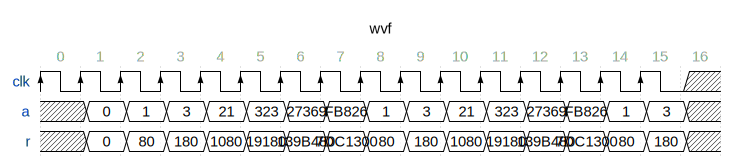

In [2]:
hw = py4hw.HWSystem()

a = hw.wire('a', 32)
r = hw.wire('r', 32)

py4hw.Sequence(hw, 'a', [1, 3, 0x21, 0x323, 0x27369, 0xFB826], a)

dut = ShiftLeftConstant(hw, 'sl', a, 7, r)

wvf = py4hw.Waveform(hw, 'wvf', [a,r])

hw.getSimulator().clk(15)

wd.render(str(wvf.get_wavedrom(shortNames=True)))

In [3]:
rtl = py4hw.VerilogGenerator(dut)
verilog = rtl.getVerilogForHierarchy(noInstanceNumberInTopEntity=False)
print(verilog)

transpiling /HWSystem[HWSystem]/ShiftLeftConstant[sl]
// This file was automatically created by py4hw RTL generator
module ShiftLeftConstant_2408c19a5d0 (
	input [31:0] a,
	output  reg [31:0] r);
// Code generated from propagate method
// wire/variable declaration
// initial
initial
begin
end
// process
always @(*)
begin
    r<=a<<7;
end
endmodule



In this case, the transpiler generates Verilog using the runtime value of n. This means that for every instantiation of the circuit it will generate a different module.

If you want to avoid this you typically use parameters in Verilog.

## A circuit with parameters
Now with parameters

In [4]:
import py4hw

class ShiftLeftConstant(py4hw.Logic):
    def __init__(self, parent, name: str, a: py4hw.Wire, n: int, r: py4hw.Wire):
        super().__init__(parent, name)
        self.a = self.addIn('a', a)
        self.r = self.addOut('r', r)
        
        self.addParameter('n', n)

    def propagate(self):
        self.r.put(self.a.get() << self.getParameterValue('n'))

        

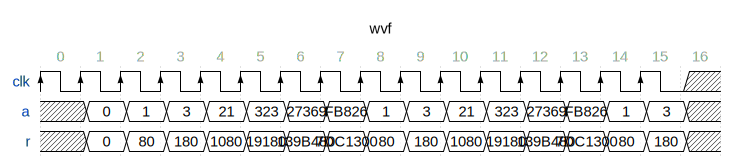

In [5]:
hw = py4hw.HWSystem()

a = hw.wire('a', 32)
r = hw.wire('r', 32)

py4hw.Sequence(hw, 'a', [1, 3, 0x21, 0x323, 0x27369, 0xFB826], a)

dut = ShiftLeftConstant(hw, 'sl', a, 7, r)

wvf = py4hw.Waveform(hw, 'wvf', [a,r])

hw.getSimulator().clk(15)

wd.render(str(wvf.get_wavedrom(shortNames=True)))

In [6]:
rtl = py4hw.VerilogGenerator(dut)
verilog = rtl.getVerilogForHierarchy()
print(verilog)

transpiling /HWSystem[HWSystem]/ShiftLeftConstant[sl]
// This file was automatically created by py4hw RTL generator
module ShiftLeftConstant #( 
	parameter n)
 (
	input [31:0] a,
	output  reg [31:0] r);
// Code generated from propagate method
// wire/variable declaration
// initial
initial
begin
end
// process
always @(*)
begin
    r<=a<<n;
end
endmodule



this circuit generates a Verilog with a parameter

In [7]:
rtl = py4hw.VerilogGenerator(hw)
verilog = rtl.getVerilog()
print(verilog)

// This file was automatically created by py4hw RTL generator
module HWSystem_2408dafa790 (
	input clk);
wire [31:0] w_a;
wire [31:0] w_r;

Sequence_2408daf9f10 i_a(.clk(clk),.r(w_a));
ShiftLeftConstant_2408d7385d0 #(.n(7)) i_sl(.a(w_a),.r(w_r));
Waveform_2408daf9b10 i_wvf(.clk(clk),.a(w_a),.r(w_r));
endmodule



## Summary
- Parameters are used to generate Verilog Parameters